# Projet de Simulation et Monte-Carlo

## Sélection de variables

**Introduction** : dans ce NoteBook, nous vous présentons trois méthodes de sélection de variables dans une régression linéaires, toutes basées sur des méthodes inspirées du cours de Simulation et Monte-Carlo. Notre objectif d'optimisation repose sur la minimisation des critères d'information propres à une régression linéaire, l'AIC et le BIC.  Chacune de nos approches aborde le problème différemment, et nous ne prétendons pas proposer des méthodes parfaites ou infaillibles. De l'incertitude demeure autour de chaque approche, même si nous avons eu du mal à la quantifier.  

### Première partie : méthode de l'entropie croisée

L'objectif de cette méthode est de sélectionner, parmi nos p régresseurs, l'ensemble de variables qui minimise l'AIC ou le BIC (choix à effectuer). Le critère de sélection est que le paramètre $\theta$ de la distribution de Bernoulli relatif à ce régresseur soit *in fine* proche de 1.  
L'idée fondamentale repose sur notre représentation initiale des p régresseurs en tant que réalisations de lois de Bernoulli de paramètre $\theta_p$ : lorsque la réalisation vaut 1, alors on prend en compte cette variable dans la régression. Cette représentation est relativement simple à comprendre car elle se base sur une des lois les plus facilement simulables, en plus d'être naturelle (en tant que variable binaire). La taille de notre matrice est donc $n\times p$, ou $n$ correspond à la taille de notre jeu de données, et $p$ correspond au nombre de variables utilisées pour notre régression (notre base communément appelée $X$).

$$\left(\begin{array}{ccccc}
\mathcal{B}(\theta_1)&\mathcal{B}(\theta_2)&\mathcal{B}(\theta_3)&\cdots&\mathcal{B}(\theta_p)\\
\mathcal{B}(\theta_1)&\mathcal{B}(\theta_2)&\mathcal{B}(\theta_3)&\cdots&\mathcal{B}(\theta_p)\\
\vdots&\vdots&\vdots&\cdots&\vdots\\
\vdots&\vdots&\vdots&\cdots&\vdots\\
\mathcal{B}(\theta_1)&\mathcal{B}(\theta_2)&\mathcal{B}(\theta_3)&\cdots&\mathcal{B}(\theta_p)\\
\end{array}\right)$$

Le fonctionnement de l'algorithme est le suivant : 
- **Initialisation** : on initialise notre matrice de Bernoulli de taille $n\times p$ en attribuant à chaque cellule un paramètre de $\frac{1}{2}$. On créé un vecteur ligne de taille $p$ appelé `new_theta` qui stockera les nouveaux paramètres optimisés à chaque itérations. Les vecteurs de chaque itérations seront stockés au fur et à mesure dans la matrice `mat_new_theta`.  
- **Boucle** : 
    - on réalise $n$ régressions linéaires en choisissant, pour chacune d'entre elles, les variables pour lesquelles les réalisations de Bernoulli de la ligne attribuée valent $1$. On calcule alors l'AIC/BIC de chaque régression que l'on stocke dans une liste, qui est de fait de dimension $n$.
    - on range nos critères dans l'ordre croissant au sein d'une liste nommée `liste_critere_sorted`.  
    - enfin, pour chaque colonne, on fait la moyenne des $x$ meilleures composantes (la moyenne des $1$ présents sur chaque ligne de cette colonne), *i.e* les lignes qui font partie des lignes pour lesquelles les critères d'information sont dans la liste `liste_critere_sorted`. On constitue alors un vecteur ligne de taille $p$, que l'on considère comme un vecteur de nouveaux paramètres $(\theta_1,\cdots,\theta_p)$, qui est nommé `new_theta`. On recrée alors une matrice de Bernoulli de taille $n\times p$ donc les paramètres des colonnes correspondent à ceux du vecteur `new_theta`.
    - on réitère alors le processus jusqu'à ce qu'il y ait convergence des nouveaux vecteurs de paramètres : le critère d'arrêt correspond à `np.linalg.norm(mat_new_theta[t] - mat_new_theta[t-1])<1e-11`.
    **Remarque** : le critère d'arrêt peut varier. Il peut peut être parfois extrêmement long d'atteindre une distance aussi faible entre les deux vecteurs. On peut éventuellement le remplacer par `1e-9`, ou encore `1e-6`.
- **Résultat** : on affiche finalement le vecteur final de paramètres (de dimension $p$). On choisit les composantes dont les paramètres sont les plus proches de 1. Il arrive souvent que l'on obtienne des $1$ ou des $0$, ce qui facilite le choix final.    

**Quelques remarques** :  
- Lorsque l'on affiche le graphe des distances de chaque vecteur de paramètre (ce qui est automatisé dans chaque fonction), il arrive que l'on atteigne difficilement une convergence : on obtient une forme de *fuzzy caterpillar*. Aussi, particulièrement pour le critère AIC, le programme peut mettre énormément de temps à tourner.  
- Lorsque l'on fait varier le nombre d'AIC/BIC que l'on choisit à chaque itération (les $x$ meilleures composantes évoquées précédemment), le temps de convergence augmente avec le nombre choisit. Pour faire un test, on fera attention à choisir un nombre de l'ordre de 10-20 pour ne pas que ça prenne trop longtemps.  
- La fonction BIC converge beaucoup plus rapidement que la fonction AIC. On obtient le même vecteur de paramètres en un nombre d'itérations souvent plus faible.

In [1]:
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import numpy as np               # IMPORTATION DES MODULES NÉCESSAIRES
import statsmodels.api as sm
from scipy import *

In [2]:
# Y : la colonne à prédire
# x : les colonnes pour prédire

def selected_variables_aic(Y,x,nb_aic):
    n = x.shape[0] # on rentrera la taille de notre échantillon
    p = x.shape[1] # on rentrera le nombre de régresseurs
    # Initialisation des vecteurs
    normes = []
    vecteur_theta = 0.5*np.ones(p)
    mat_bernoulli = np.zeros((n,p))
    for i in range(p):
        mat_bernoulli[:,i] = bernoulli.rvs(vecteur_theta[i], size=n)
        # initialisation de la matrice de Bernoulli avec des 
        # paramètres 1/2
    t=0
    new_theta = np.zeros((p))
    mat_new_theta = np.ones((p))

    while True:
        liste_aic = []
        indices_var = []
        liste_bon_indice = []
        u=[]
        for i in range(n): # on parcourt les rangs de la matrice
             # indices des variables que l'on sélectionne pour l'OLS
            indices_var = [idx for idx,e in enumerate(mat_bernoulli[i]) 
                           if e == 1]
            X_reg = x.iloc[:, indices_var]
            X = sm.add_constant(X_reg)
            model = sm.OLS(Y,X)
            results = model.fit() # éxecution de la régression
            liste_aic.append(results.aic) # on ajoute les AIC de chaque regression
        liste_aic_sorted = sorted(liste_aic)
        # maintenant, on va faire une liste de nouveaux paramètres pour
        # chaque colonne, ou on va faire la moyenne des 0 et des 1
        # lorsque l'on est sur une ligne de "bon" AIC
        for i in range(n): # liste des indices des nb meilleurs AIC
            if liste_aic[i] in liste_aic_sorted[:nb_aic]:
                liste_bon_indice.append(i)
        for j in range(p): # itération sur les colonnes de la matrice
            for i in liste_bon_indice: 
                u.append(mat_bernoulli[i,j])
                new_theta[j] = np.mean(u) # on fait la moyenne des composantes dont les lignes
                # sont parmi celles réalisant les meilleurs AIC
        mat_new_theta = np.vstack((mat_new_theta,[new_theta]))
        # on rentre maintenant le critère d'arrêt
        if np.linalg.norm(mat_new_theta[t] - mat_new_theta[t-1])<1e-11:
            for i in range(1,mat_new_theta.shape[0]):
                normes.append(np.linalg.norm(mat_new_theta[i] - mat_new_theta[i-1]))
            print("Le nombre d'itérations est "+ str(t)+"\n"+"Les paramètres de Bernoulli finaux sont : "+ str(mat_new_theta[t]))
            plt.figure(figsize=(20,10))
            plt.plot(range(1,mat_new_theta.shape[0]),normes,"r")
            plt.ylabel('Normes des vecteurs de paramètres')
            plt.xlabel("Nombre d'itérations")
            plt.show()
            break
        else:
            for i in range(p):
                mat_bernoulli[:,i] = bernoulli.rvs(new_theta[i], size=n) 
                # on réinitialise la matrice avec les nouveaux 
                # paramètres de Bernoulli
        t=t+1 

In [3]:
def selected_variables_bic(Y,x,nb_bic):
    n = x.shape[0] # on rentrera la taille de notre échantillon
    p = x.shape[1] # on rentrera le nombre de régresseurs
    # Initialisation des vecteurs
    normes = []
    vecteur_theta = 0.5*np.ones(p)
    mat_bernoulli = np.zeros((n,p))
    for i in range(p):
        mat_bernoulli[:,i] = bernoulli.rvs(vecteur_theta[i], size=n)
    t=0
    new_theta = np.zeros((p))
    mat_new_theta = np.ones((p))

    while True:
        liste_bic = []
        indices_var = []
        liste_bon_indice = []
        u=[]
        for i in range(n): # on parcourt les rangs de la matrice
             # indices des variables que l'on sélectionne pour l'OLS
            indices_var = [idx for idx,e in enumerate(mat_bernoulli[i]) 
                           if e == 1]
            X_reg = x.iloc[:, indices_var]
            X = sm.add_constant(X_reg)
            model = sm.OLS(Y,X)
            results = model.fit() # éxecution de la régression
            liste_bic.append(results.bic) # on ajoute les AIC de chaque regression
        liste_bic_sorted = sorted(liste_bic)
        # maintenant, on va faire une liste de nouveaux paramètres pour
        # chaque colonne, ou on va faire la moyenne des 0 et des 1
        # lorsque l'on est sur une ligne de "bon" AIC
        for i in range(n): # liste des indices des nb meilleurs BIC
            if liste_bic[i] in liste_bic_sorted[:nb_bic]:
                liste_bon_indice.append(i)
        for j in range(p): # itération sur les colonnes de la matrice
            for i in liste_bon_indice:
                u.append(mat_bernoulli[i,j])
                new_theta[j] = np.mean(u) # on fait la moyenne des composantes dont les lignes
                # sont parmi celles réalisant les meilleurs AIC
        mat_new_theta = np.vstack((mat_new_theta,[new_theta]))
        # on rentre maintenant le critère d'arrêt
        if np.linalg.norm(mat_new_theta[t] - mat_new_theta[t-1])<1e-11:
            for i in range(1,mat_new_theta.shape[0]):
                normes.append(np.linalg.norm(mat_new_theta[i] - mat_new_theta[i-1]))
            print("Le nombre d'itérations est "+ str(t)+"\n"+"Les paramètres de Bernoulli finaux sont : "+ str(mat_new_theta[t]))
            plt.figure(figsize=(20,10))
            plt.plot(range(1,mat_new_theta.shape[0]),normes,"r")
            plt.ylabel('Normes des vecteurs de paramètres')
            plt.xlabel("Nombre d'itérations")
            plt.show()
            break
        else:
            for i in range(p):
                mat_bernoulli[:,i] = bernoulli.rvs(new_theta[i], size=n)
                # on réinitialise la matrice avec les nouveaux 
                # paramètres de Bernoulli
        t=t+1 

Création de la base de données grâce à un module Python dédié à la création de bases pour la régression linéaire :

In [4]:
import numpy as np
from sklearn import datasets
import pandas as pd
from statsmodels.api import OLS
from itertools import combinations
from time import time
import matplotlib.pyplot as plt
from math import *
from random import randint

def gen_data(n_samples = 1000, n_features = 10,n_informative = 5, noise = 1, coef = True, random_state = 2020):
    #We set the random_state to get reproductible results
    data, y, coef = datasets.make_regression(n_samples = n_samples, #The number of samples
                                             n_features = n_features, # The number of features
                                             n_informative = n_informative, # the number of features used to build the linear model used to generate the output
                                             noise = noise, #The standard deviation of the gaussian noise applied to the output
                                             coef = coef, #If True, the coefficients of the underlying linear model are returned.
                                            random_state = random_state #Determines random number generation for dataset creation.
                                            )
    X = pd.DataFrame(data)
    Y = pd.DataFrame(y)
    beta_true = pd.DataFrame(coef)
    
    return X,Y,beta_true

X, y, beta_true = gen_data()

Quelques tests :

Le nombre d'itérations est 29
Les paramètres de Bernoulli finaux sont : [1.         1.         1.         1.         0.8        0.66666667
 0.71428571 0.75       0.66666667 0.7       ]


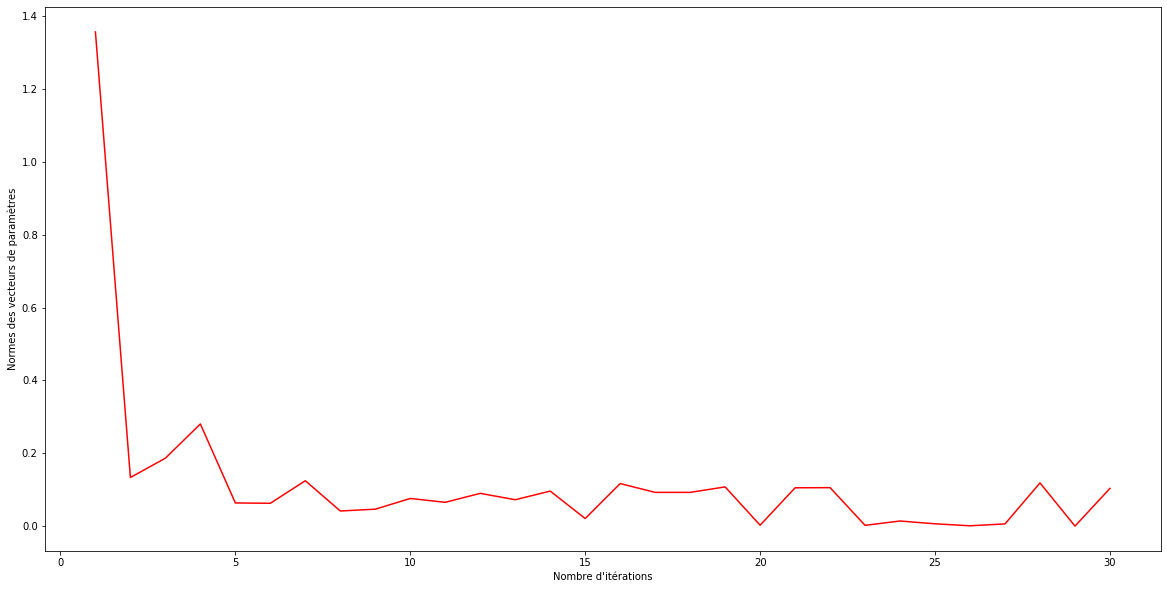

In [6]:
selected_variables_aic(y,X,10)

Le nombre d'itérations est 9
Les paramètres de Bernoulli finaux sont : [1.         1.         1.         1.         0.8        0.66666667
 0.71428571 0.75       0.66666667 0.7       ]


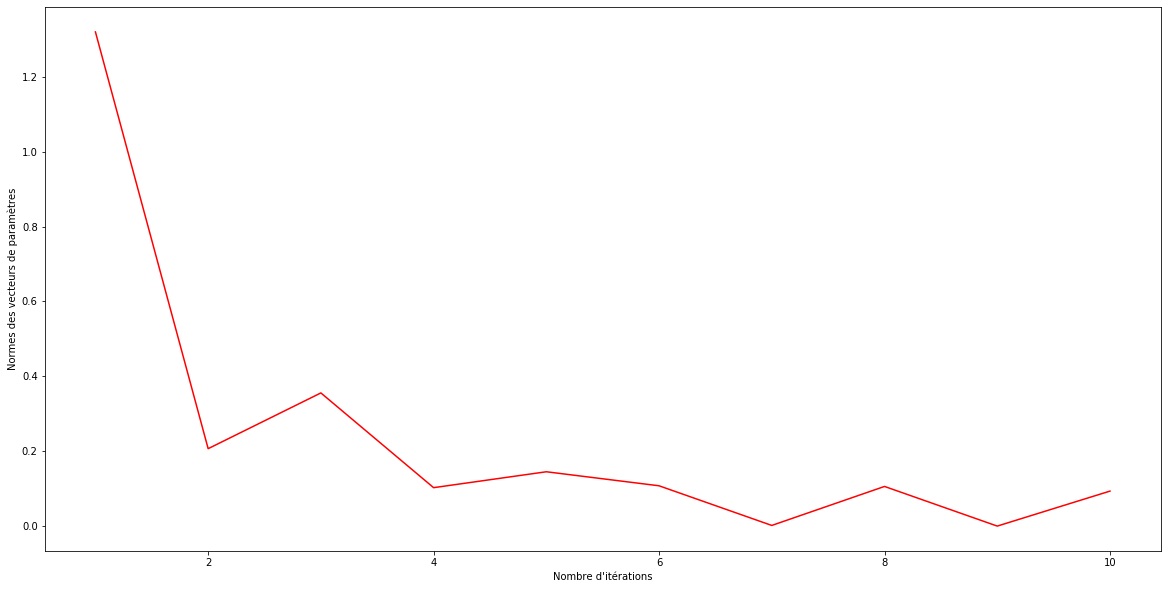

In [8]:
selected_variables_bic(y,X,10)

Le nombre d'itérations est 15
Les paramètres de Bernoulli finaux sont : [1.         1.         1.         1.         1.         0.83333333
 0.85714286 0.875      0.77777778 0.8       ]


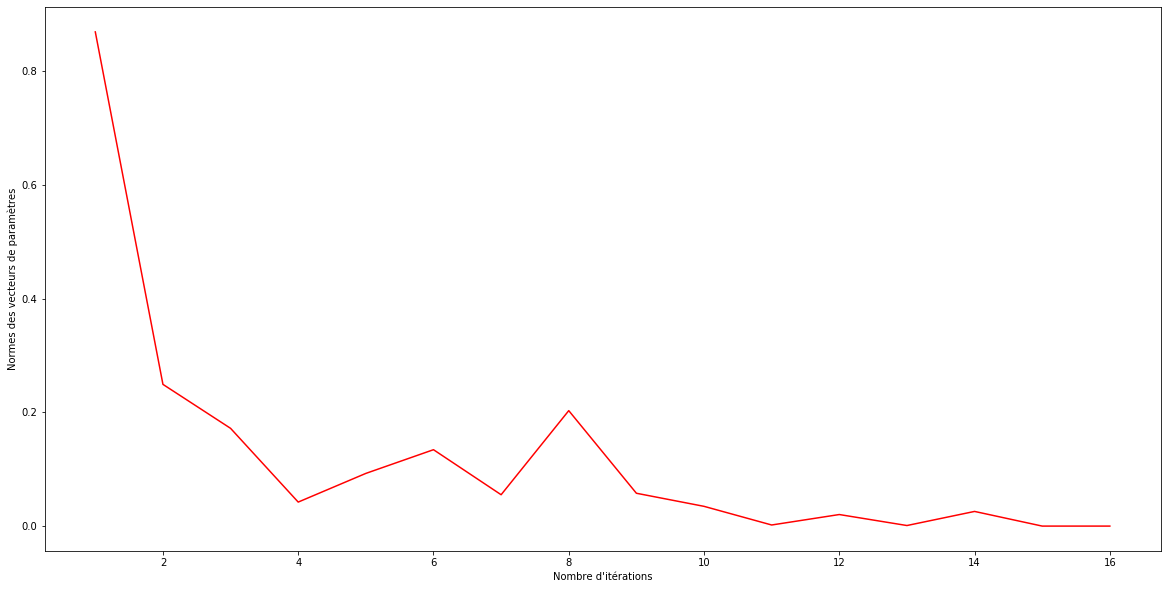

In [9]:
selected_variables_bic(y,X,20)

Le nombre d'itérations est 34
Les paramètres de Bernoulli finaux sont : [1.         1.         1.         1.         0.95333333 0.79444444
 0.82380952 0.84583333 0.77037037 0.79333333]


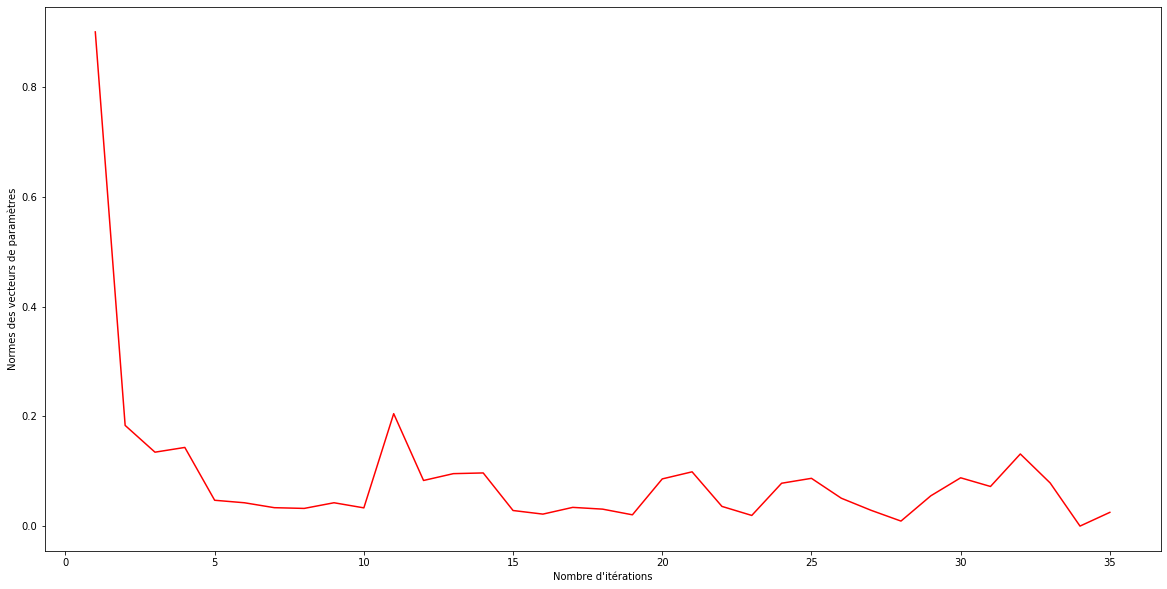

In [11]:
selected_variables_bic(y,X,30)

### Deuxième partie : Recuit simmulé en utilisant un noyeau de type Hasting Metropolis

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from copy import deepcopy
from random import randint
from sklearn import datasets
from itertools import combinations


from scipy import stats
import seaborn as sns
import statsmodels.api as sm

On comence par créer une base de données

In [ ]:

def gen_data(n_samples = 1000, n_features = 10,n_informative = 3, noise = 1, coef = True, random_state = 2020):
    #We set the random_state to get reproductible results
    data, y, coef = datasets.make_regression(n_samples = n_samples, #The number of samples
                                             n_features = n_features, # The number of features
                                             n_informative = n_informative, # the number of features used to build the linear model used to generate the output
                                             noise = noise, #The standard deviation of the gaussian noise applied to the output
                                             coef = coef, #If True, the coefficients of the underlying linear model are returned.
                                            random_state = random_state #Determines random number generation for dataset creation.
                                            )
    X = pd.DataFrame(data)
    Y = pd.DataFrame(y)
    beta_true = pd.DataFrame(coef)
    
    return X,Y,beta_true
​
X, y, beta_true = gen_data()

On cherche bêtement le meilleur estimateur:

In [ ]:
#fait la liste de tous les modeles possibles - toutes les combinaisons de parametres possibles
#2**k - 1 possibilites (on ne considere pas le model ou on regresse sur rien)
def get_models(k) : 
    models = []
    for n_param in range(1, k+1) :         
        models.extend(list(combinations([i for i in range(k)], n_param)))
    return models

# cherche le meilleur model parmi les models possibles

def find_best_model_OLS(X, y, criterion) : 
    t0 = time.time()
    k = X.shape[1]            # nb de potentiels predicteurs
    models = get_models(k)    
    results = []
    n_models = len(models)
    counter = 0
    
    for model in list(models) :    # calcul de la regression pour tous les models possibles
        X_curr = X[list(model)]
        X_curr = sm.add_constant(X_curr)
        ols = sm.OLS(y, X_curr)
        result = ols.fit()
        if criterion == 'AIC' :
            results.append(result.aic)
        elif criterion == 'BIC' :
            results.append(result.bic)
        counter += 1
        
    best_criterion = np.argmin(results)
    best_model = models[best_criterion]
    times = time.time() - t0
    
    
    return best_model, results[best_criterion], times

On peut ensuite effectuer la méthode du recuit simmulé pour comparer le résultat

In [ ]:
def changer(liste): #Cette fonction permet de changer un bit dans une liste de nombres binaires
    liste_tamp=deepcopy(liste)
    liste_save=deepcopy(liste)
    var=randint(0,len(liste[1])-1)
    liste_tamp[1][var]=np.abs(liste_tamp[1][var]-1) #Transforme 0 en 1 et 1 en 0
    #On enlève le cas où il y a que des zéros
    indicateur_un=0
    for i in liste_tamp[1]:
        if i==1:
            indicateur_un=1
    if indicateur_un==0:
        liste_tamp=changer(liste_save)
    return liste_tamp

In [ ]:
def regresseurs(df,liste): #Cette fonction prends en argument une liste de nomvre binaires et renvoie la liste des régresseurs associés
    liste_regresseur=[]
    for i in range (len(liste[1])):
        if liste[1][i]==1:
            liste_regresseur.append(liste[0][i])
    X=df[liste_regresseur]
    return X   

In [ ]:
def critere(X,y,criterion):
    X = sm.add_constant(X) #On ajoute la constante
    model = sm.OLS(y, X)
    results = model.fit()
    if criterion=='BIC':
        return results.bic
    else:
        return results.aic

In [ ]:
def recuit(X,y,kmax,T0,emax,criterion): #Cette fonction met en oeuvre l'alorithme du recuit
    
    date_debut=time.time()
    
    X1=X.copy()
    
    colonnes=X1.columns
    
    T=T0
    indicateur=[1 for _ in range(len(colonnes))]
    liste=[colonnes, indicateur]
    
    liste_tamp=deepcopy(liste)
    
    e = critere(regresseurs(X,liste),y,criterion) #où e est la fonction à minimiser (ici critère AIC ou BIC)
    e_tamp=e
    k = 0

    while k < kmax and e > emax:
        liste_n = changer(liste) 
        e_n = critere(regresseurs(X,liste_n),y,criterion)
        
        aleatoire=x=np.random.random_sample(1,)[0]
        if e_n < e or aleatoire < np.exp(-(e_n-e)/T):
            liste=deepcopy(liste_n)
            e=e_n
            if e < e_tamp:
                liste_tamp=deepcopy(liste)
                e_tamp=e
        T=0.99*T
        k+=1

    temps=time.time()-date_debut
        
    return [regresseurs(X,liste_tamp).columns, e_tamp, temps]

On fait un test

In [76]:
find_best_model_OLS(X,y,'AIC')

((0, 1, 2, 3, 4, 6, 7, 8, 9), 2862.0616089237137, 3.1363604068756104)

In [75]:
recuit(X,y,1,1000,5000,-1000,'AIC')

[Int64Index([0, 1, 2, 3, 4, 6, 7, 8, 9], dtype='int64'),
 2862.0616089237137,
 3.744290351867676]

On observe l'impact des différents paramètres

In [8]:
target=find_best_model_OLS(X,y,'AIC')

Test de l'influence du nombre d'étapes

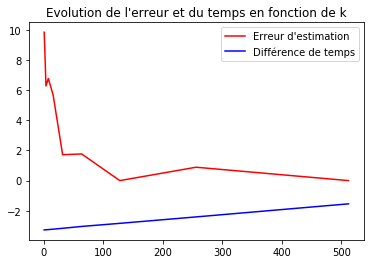

In [14]:
liste_k=[2**i for i in range(0,10)]
precision=[]
temps=[]
for k in (liste_k):
    res=recuit(X,y,1,k,1000,-200,'AIC')
    precision.append(res[1]-target[1])
    temps.append(res[2]-target[2])
plt.plot(liste_k,precision,'r', label='Erreur d\'estimation ')
plt.plot(liste_k,temps,'b', label='Différence de temps')
plt.legend(loc='upper right')
plt.title('Evolution de l\'erreur et du temps en fonction de k')
plt.show()

L'algorithme trouve le résultat assez vite, 256 étapes suffisent à trouver le bon résultat

Test de l'influence de la température:

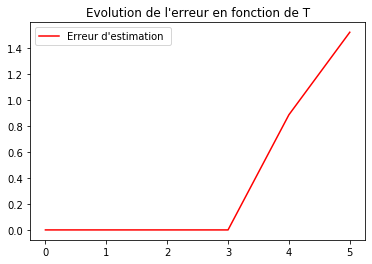

In [15]:
liste_T=[10**i for i in range(0,6)]
precision=[]
for T in (liste_T):
    res=recuit(X,y,1,256,T,-200,'AIC')
    precision.append(res[1]-target[1])
plt.plot(np.log10(liste_T),precision,'r', label='Erreur d\'estimation ')
plt.legend(loc='upper left')
plt.title('Evolution de l\'erreur en fonction de T')
plt.show()

Si on donne une valeur trop élevée de la température, on perd en précision

Test de l'influence de la proportion de variables explicatives:

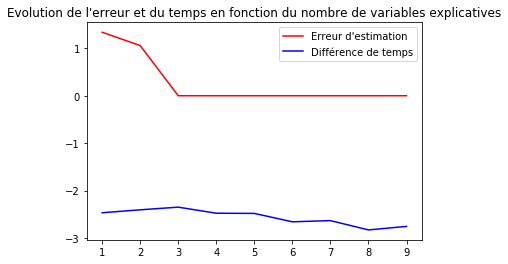

In [17]:
liste_ex=[i for i in range(1,10)]
precision=[]
temps=[]
for ex in (liste_ex):
    X1, y1, beta_true = gen_data(n_informative = ex)
    target=find_best_model_OLS(X1,y1,'AIC')
    res=recuit(X1,y1,1,256,1000,-200,'AIC')
    precision.append(res[1]-target[1])
    temps.append(res[2]-target[2])
plt.plot(liste_ex,precision,'r', label='Erreur d\'estimation ')
plt.plot(liste_ex,temps,'b', label='Différence de temps')
plt.legend(loc='upper right')
plt.title('Evolution de l\'erreur et du temps en fonction du nombre de variables explicatives')
plt.show()

Le nombre de variables explicatives ne semble pas avoir beaucoup d'impact sur la précision et le temps de calcul.

Test de l'influence du nombre de variables:

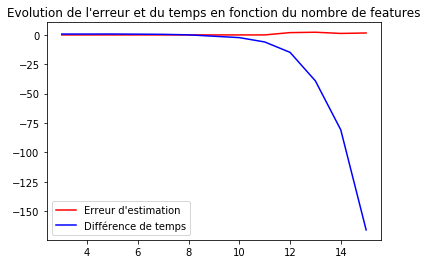

In [18]:
liste_var=[i for i in range(3,16)]
precision=[]
temps=[]
for var in (liste_var):
    X1, y1, beta_true = gen_data(n_features = var, n_informative = int(np.floor(var/3)))
    target=find_best_model_OLS(X1,y1,'AIC')
    res=recuit(X1,y1,1,256,1000,-200,'AIC')
    precision.append(res[1]-target[1])
    temps.append(res[2]-target[2])
plt.plot(liste_var,precision,'r', label='Erreur d\'estimation ')
plt.plot(liste_var,temps,'b', label='Différence de temps')
plt.legend(loc='lower left')
plt.title('Evolution de l\'erreur et du temps en fonction du nombre de features')
plt.show()

On en conclut que temporellement parlant, plus il y a de variable et plus cette méthode est intéressante

### Troisième partie : Recuit simulé par un noyau de Gibbs

In [1]:
import numpy as np
from sklearn import datasets
import pandas as pd
from statsmodels.api import OLS
from itertools import combinations
from time import time
import matplotlib.pyplot as plt
from math import *
from random import randint

### Définition du problème

In [2]:
def gen_data(n_samples = 1000, n_features = 10,n_informative = 5, noise = 1, coef = True, random_state = 2020):

    data, y, coef = datasets.make_regression(n_samples = n_samples, n_features = n_features, n_informative = n_informative,
                                             noise = noise, coef = coef, random_state = random_state)
    X = pd.DataFrame(data)
    Y = pd.DataFrame(y)
    beta_true = pd.DataFrame(coef)
    
    return X,Y,beta_true

X, y, beta_true = gen_data()

In [3]:
#On fait la liste de tous les modeles possibles - toutes les combinaisons de parametres possibles
#2**k - 1 possibilites (on ne considere pas le model ou on regresse sur rien)
def get_models(k) : 
    models = []
    for n_param in range(1, k+1) :         
        models.extend(list(combinations([i for i in range(k)], n_param)))
    return models

#On cherche le meilleur modèle parmi les models possibles

def find_best_model_OLS(X, y, criterion = 'AIC') : 
    t0 = time()
    k = X.shape[1]            # nb de potentiels predicteurs
    models = get_models(k)    
    results = []
    n_models = len(models)
    print('Considering {} models ..'.format(n_models))
    counter = 0
    
    for model in list(models) :    # calcul de la regression pour tous les models possibles
        if counter%500 == 0 : 
            print('Fitted {}/{} models'.format(counter,n_models))
        X_curr = X[list(model)]
        ols = OLS(y, X_curr)
        result = ols.fit()
        if criterion == 'AIC' :
            results.append(result.aic)
        elif criterion == 'BIC' :
            results.append(result.bic)
        counter += 1
        
    best_criterion = np.argmin(results)
    best_model = models[best_criterion]
    times = time() - t0
    
    print('\nTotal fitting time : {}s'.format(round(times,3)))
    
    return best_model, results[best_criterion], times

In [4]:
find_best_model_OLS(X,y)

Considering 1023 models ..
Fitted 0/1023 models
Fitted 500/1023 models
Fitted 1000/1023 models

Total fitting time : 1.995s


((0, 1, 6, 7, 9), 2858.6377710409324, 1.9954729080200195)

In [5]:
# permet de connaître le nom des colonnes à renvoyer
def get_col_name(bool_vec, X): 
    X = pd.DataFrame(X)
    return X.columns[pd.Series(bool_vec) == 1].tolist()

In [6]:
# on defintit l'énergie par des criteres AIC ou BIC

def get_energy(y, X, criterion):
    if X.shape[1] == 0 :
        return inf
    model = OLS(y, X)        
    results = model.fit()
    
    if criterion == 'AIC':
        return results.aic
    elif criterion == 'BIC':
        return results.bic

In [7]:
def get_acceptance_probability(energy_curr, energy_new, T):
    if energy_new < energy_curr : 
        return 1 
    return np.exp((energy_curr - energy_new) / T)

In [8]:
def gibbs_sampler(init_vector, X, y):
    global criterion
    E = get_energy(y, X[get_col_name(init_vector, X)], criterion)
   
    for i in range(len(init_vector)):
        bool_vec = init_vector.copy()
        bool_vec[i] = 1 - init_vector[i]
        
        subset = X[get_col_name(bool_vec, X)]
        E1 = get_energy(y, subset, criterion)
        
        if E1 < E: 
            E = E1
            init_vector = bool_vec
        
    
    return init_vector

In [9]:
from time import time
def result(y, X, init_temp = 5, temp_terminal = 0.001, cooling_rate = 0.8, init_vector = None, return_states = False):
    state_evolution = []
    all_state = []
    t0 = time()
    
    if init_vector == None : 
        init_vector = np.ones(X.shape[1])
    T = init_temp               # c'est le grand T de l'energie
    X_init = X[get_col_name(init_vector,X)]
    
    
    E = get_energy(y, X_init, criterion)
    
    
    while T > temp_terminal:
        new_vec = gibbs_sampler(init_vector, X, y)
        X_new = X[get_col_name(new_vec, X)]
        E1 = get_energy(y, X_new, criterion = criterion)
        if get_acceptance_probability(E, E1, T) > np.random.random(): 
            E = E1
            init_vector = np.copy(new_vec)
        T *= cooling_rate
        
    fit_time = time() - t0
    print('Fitting time : {}s'.format(round(fit_time,3)))
    return get_col_name(init_vector, X), fit_time

In [10]:
criterion = "AIC"
result(y, X)

Fitting time : 1.157s


([0, 1, 6, 7, 9], 1.1572809219360352)

On a obtenu ces résultats pour k = 10, on cherche désormais à observer cet algorithme lorsque l'on augmente le nombre de features.

In [11]:
X_50, y_50, beta_50 = gen_data(n_features=50)

In [12]:
print('True values for beta : {}'.format(list(beta_50[beta_50[0]!=0].index)))

True values for beta : [4, 5, 6, 38, 45]


In [17]:
beta_50

,0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,37.851915
5,94.207499
6,68.289252
7,0.000000
8,0.000000
9,0.000000


In [27]:
criterion = "AIC"
result(y_50, X_50)

Fitting time : 6.398s


([4, 5, 6, 11, 18, 20, 22, 35, 36, 38, 45], 6.3976781368255615)

Le sous ensemble de prédicteurs obtenus par gibbs sampling est différent de celui optimal. \
Encore une fois, l'AIC ne pénalise pas suffisamment. Essayons avec le BIC

In [26]:
criterion = "BIC"
result(y_50, X_50)

Fitting time : 5.865s


([4, 5, 6, 38, 45], 5.864926815032959)

In [66]:
number_of_samples = [10,30,50,100,250,400,650,900,1200,1500,2000]
AIC = []
BIC = []
time_AIC = []
time_BIC = []
for i in number_of_samples:
    X , y , beta = gen_data(n_samples = i, n_features = 50)
    criterion = "AIC"
    L,t = result(y,X)
    print(L,t)
    U = list(beta_50[beta_50[0]!=0].index)
    AIC.append((len(L)-len(U))/50)
    time_AIC.append(t)
       
    criterion = "BIC"
    L,t = result(y,X)
    print(L,t)
    U = list(beta_50[beta_50[0]!=0].index)
    BIC.append((len(L)-len(U))/50)
    time_BIC.append(t)
    

Fitting time : 5.168s
[0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] 5.168054103851318
Fitting time : 4.47s
[0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49] 4.470384120941162
Fitting time : 5.965s
[3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49] 5.965257883071899
Fitting time : 5.45s
[3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49] 5.4495720863342285
Fitting time : 7.989s
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33

In [67]:
AIC, time_AIC

([0.82, 0.78, 0.9, 0.06, 0.16, 0.16, 0.2, 0.14, 0.06, 0.22, 0.14],
 [5.168054103851318,
  5.965257883071899,
  7.98858118057251,
  5.361044883728027,
  5.426371812820435,
  5.886652946472168,
  7.124712944030762,
  6.599707841873169,
  5.929455757141113,
  9.092942953109741,
  7.823274374008179])

In [68]:
BIC

[0.82, 0.78, 0.9, 0.0, 0.02, 0.02, 0.04, 0.02, 0.0, 0.0, 0.0]

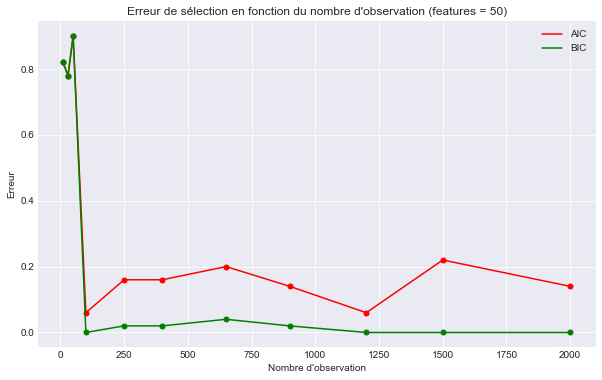

In [69]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize =(10,6))
plt.xlabel("Nombre d'observation")
plt.ylabel("Erreur")
plt.title("Erreur de sélection en fonction du nombre d'observation (features = 50)")
plt.plot(number_of_samples, AIC , 'r' , label = "AIC")
plt.plot(number_of_samples, AIC , c = 'red' , linestyle = 'none', marker = 'o',
  markersize = 5)
plt.plot(number_of_samples, BIC , 'g' , label = "BIC")
plt.plot(number_of_samples, BIC , c = 'green' , linestyle = 'none', marker = 'o',
  markersize = 5)
plt.legend()
plt.show()

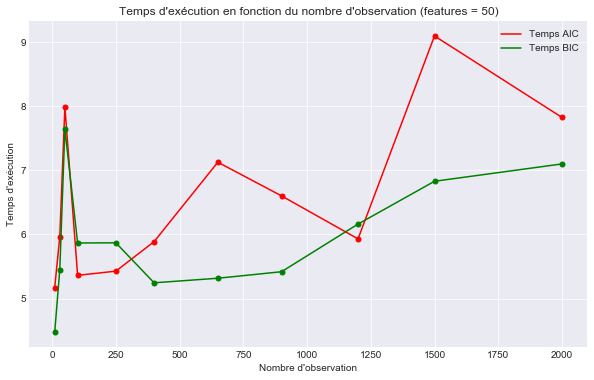

In [70]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize =(10,6))
plt.xlabel("Nombre d'observation")
plt.ylabel("Temps d'exécution")
plt.title("Temps d'exécution en fonction du nombre d'observation (features = 50)")
plt.plot(number_of_samples, time_AIC , 'r' , label = "Temps AIC")
plt.plot(number_of_samples, time_AIC , c = 'red' , linestyle = 'none', marker = 'o',
  markersize = 5)
plt.plot(number_of_samples, time_BIC , 'g' , label = "Temps BIC")
plt.plot(number_of_samples, time_BIC , c = 'green' , linestyle = 'none', marker = 'o',
  markersize = 5)
plt.legend()
plt.show()